In [25]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [40]:
# Policy evaluation

class GridWorld:
    def __init__(self, shape=[4, 4]):
        self.shape = shape
        self.n_states = np.prod(shape)
        self.n_actions = 4
        self.grid = np.zeros(shape)

        # Define terminal states
        self.grid[0, 0] = 1
        self.grid[shape[0]-1, shape[1]-1] = 1

        # Define rewards for each state and action. 
        # For the gridworld problem, reward is independent of action.
        self.rewards = np.ones_like(self.grid) * -1
        self.rewards[0, 0] = 0
        self.rewards[shape[0]-1, shape[1]-1] = 0

    def get_state(self, x, y):
        return np.ravel_multi_index((x, y), self.shape)

    def get_position(self, state):
        return np.unravel_index(state, self.shape)

    def is_terminal(self, state):
        x, y = self.get_position(state)
        return self.grid[x, y] == 1

    def get_reward(self, state):
        x, y = self.get_position(state)
        return self.rewards[x, y]

    def step(self, state, action):
        x, y = self.get_position(state)
        current_state = self.get_state(x, y)
        if ~self.is_terminal(current_state):
            if action == 0: # up
                x = max(x-1, 0)
            elif action == 1: # down
                x = min(x+1, self.shape[0]-1)
            elif action == 2: # left
                y = max(y-1, 0)
            elif action == 3: # right
                y = min(y+1, self.shape[1]-1)

        next_state = self.get_state(x, y)
        reward = self.get_reward(current_state)
        done = self.is_terminal(next_state)

        return next_state, reward, done     

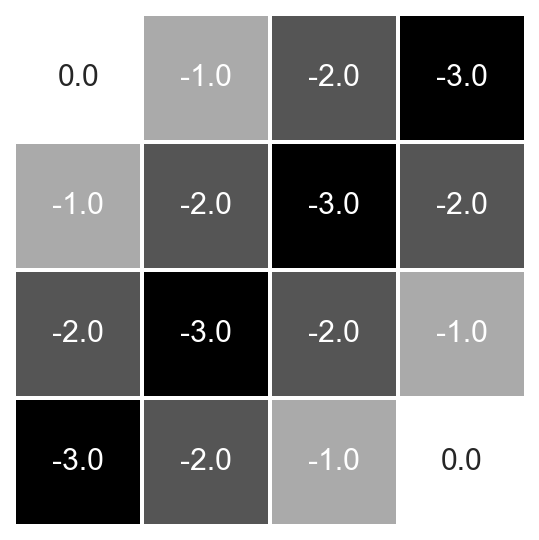

In [41]:
gridworld = GridWorld()
values = np.zeros(gridworld.n_states)
policy = np.ones((gridworld.n_states, gridworld.n_actions))/4
while True:
    # Policy evaluation
    while True:
        delta = 0
        for s in range(gridworld.n_states):
            v = values[s]
            state_value = 0
            for a in range(gridworld.n_actions):
                next_s, reward, done = gridworld.step(s, a)
                state_value += policy[s][a] * (reward + values[next_s])
            values[s] = state_value
            delta = max(delta, abs(v - values[s]))
        if delta < 1e-4:
            break

    # Policy improvement
    policy_stable = True
    for s in range(gridworld.n_states):
        old_action = np.argmax(policy[s])
        state_values = []
        for a in range(gridworld.n_actions):
            next_s, reward, done = gridworld.step(s, a)
            state_values.append(reward + values[next_s])
        new_action = np.argmax(state_values)
        if old_action != new_action:
            policy_stable = False
        policy[s] = np.eye(gridworld.n_actions)[new_action]
    
    if policy_stable:
        break


sns.heatmap(values.reshape(gridworld.shape), annot=True, cmap="gray", fmt=".1f", linewidths=2,
            cbar=False, square=True, xticklabels=False, yticklabels=False)
plt.show()

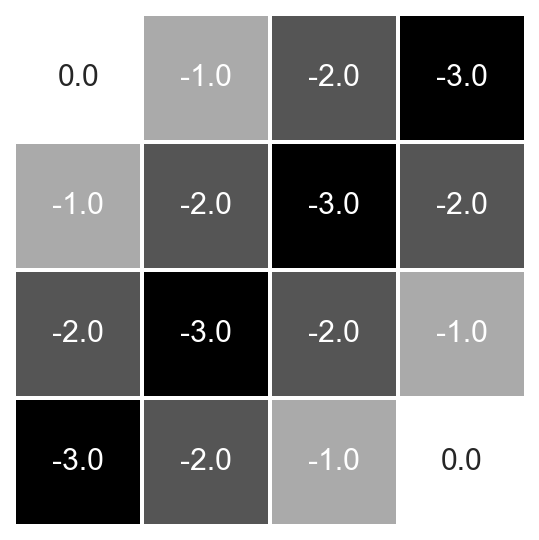

In [68]:
gridworld = GridWorld()
action_values = np.zeros((gridworld.n_states, gridworld.n_actions))
policy = np.ones((gridworld.n_states, gridworld.n_actions))/4
while True:
    # Policy evaluation
    while True:
        delta = 0
        for s in range(gridworld.n_states):
            for a in range(gridworld.n_actions):
                q_old = action_values[s][a]
                next_s, reward, done = gridworld.step(s, a)
                q_new = reward
                for next_action in range(gridworld.n_actions):
                    q_new += policy[next_s][next_action] * action_values[next_s][next_action]
                delta = max(delta, abs(q_new - q_old))
                action_values[s][a] = q_new
        if delta < 1e-4:
            break

    # Policy improvement
    policy_stable = True
    old_action = np.argmax(policy, axis=1)
    new_action = np.argmax(action_values, axis=1)
    if not np.all(old_action == new_action):
        policy_stable = False
    policy = np.zeros((gridworld.n_states, gridworld.n_actions))
    policy[np.arange(gridworld.n_states), new_action] = 1    
    if policy_stable:
        break

values = np.sum(action_values * policy, axis=1)
sns.heatmap(values.reshape(gridworld.shape), annot=True, cmap="gray", fmt=".1f", linewidths=2,
            cbar=False, square=True, xticklabels=False, yticklabels=False)
plt.show()